In [1]:
'''
Copyright (c) Microsoft Corporation. All rights reserved.
Licensed under the MIT License.
'''
### Run the following command to install required packages:
#! pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import glob
import cv2
from sklearn.model_selection import train_test_split
from collections import Counter

np.random.seed(0)
import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline
from pylab import *
from keras.models import Sequential
from keras.optimizers import Adam, SGD, Adamax
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from scipy import spatial

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform

from sklearn.manifold import TSNE
import seaborn as sns

import matplotlib.pyplot as plt

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model,normalize

from sklearn.metrics import roc_curve,roc_auc_score

Using TensorFlow backend.


In [3]:
current_dir = "./blue_whales/"

data_dir = current_dir + "data/"
labeled_data_dir = data_dir + 'labeled_data/'
spectrogram_dir = data_dir + "extracted_spectrogram/"

Dataset

In [4]:
directory_filenames =  glob.glob(spectrogram_dir + '*.png')
labels_original = ['_'.join(filename.split('/')[-1].split('_')[:2]) for filename in directory_filenames]
Counter(labels_original)

Counter({'ANT_Negative': 1099,
         'ANT_Positive': 1491,
         'AUS_Negative': 1988,
         'AUS_Positive': 1459,
         'MAD_Negative': 1187,
         'MAD_Positive': 2670,
         'SRI_Negative': 1602,
         'SRI_Positive': 659})

In [5]:
img_rows, img_cols, n_channels = 224, 224, 3
input_shape = (img_rows, img_cols, n_channels)

def buildDataSet():
    spectrogram_filenames_train, spectrogram_filenames_test, y_train_original, y_test_original = train_test_split(directory_filenames, labels_original, test_size = 0.3, random_state = 1)
    
    x_train_original = []
    x_test_original = []
    
    for i in range(len(spectrogram_filenames_train)):
        img = cv2.imread(spectrogram_filenames_train[i])  
        x_train_original.append(cv2.resize(img, (img_rows, img_cols)) / 255.0)
        
    for i in range(len(spectrogram_filenames_test)):
        img = cv2.imread(spectrogram_filenames_test[i])  
        x_test_original.append(cv2.resize(img, (img_rows, img_cols)) / 255.0)
        
    x_train = np.array(x_train_original)
    x_test = np.array(x_test_original)
    
    y_train = ['Negative' if 'Negative' in y else y for y in y_train_original]
    y_test = ['Negative' if 'Negative' in y else y for y in y_test_original]

    return x_train, x_test, y_train_original, y_test_original, y_train, y_test, spectrogram_filenames_train, spectrogram_filenames_test

x_train, x_test, y_train_original, y_test_original, y_train, y_test, spectrogram_filenames_train, spectrogram_filenames_test = buildDataSet()


Plot example mel-spectrograms for each species:


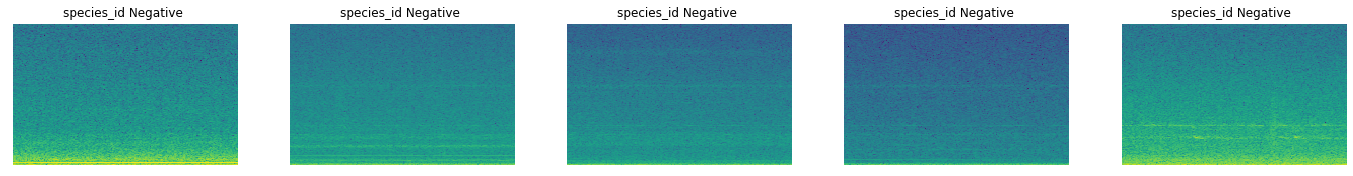

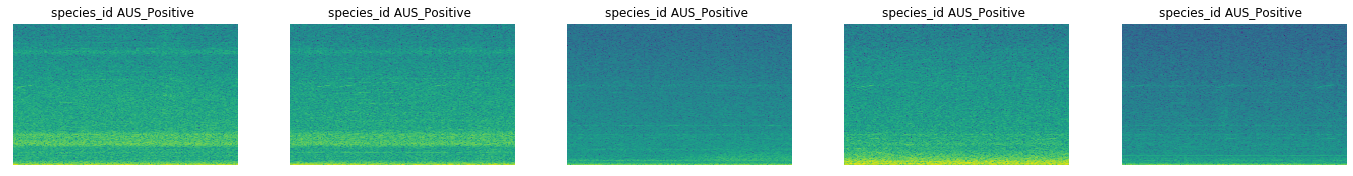

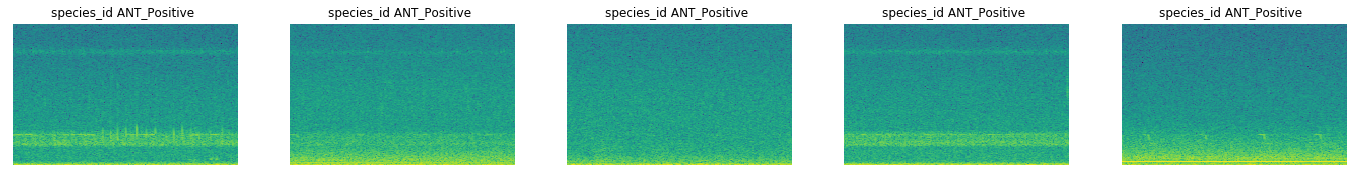

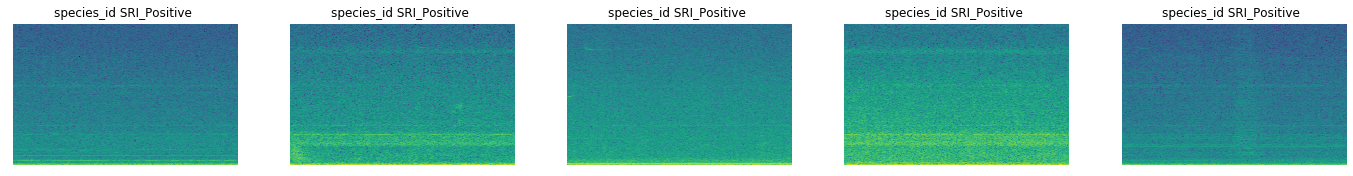

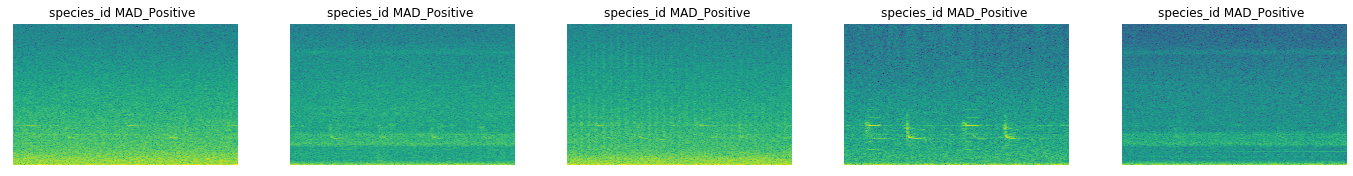

In [6]:
species_id_list = list(set(y_train))

def DrawPics(spectrogram_filenames, sample_size, template='{}', species_id=None):
    fig=plt.figure(figsize=(24, 16))
    if 'Positive' in species_id:
        spectrogram_filenames_species_id = [spectrogram_filename for spectrogram_filename in spectrogram_filenames if '_'.join(spectrogram_filename.split('/')[-1].split('_')[:2]) == species_id]
    elif 'Negative' in species_id:
        spectrogram_filenames_species_id = [spectrogram_filename for spectrogram_filename in spectrogram_filenames if 'Negative' in spectrogram_filename]
    
    N = min(sample_size,len(spectrogram_filenames_species_id))
    for m in range(sample_size):
        subplot = fig.add_subplot(1, sample_size, m+1)
        axis("off")
        if m < N:
            img = image.imread(spectrogram_filenames_species_id[m])
            plt.imshow(img)
            if (species_id!=None):
                subplot.title.set_text((template.format(species_id)))

print("Plot example mel-spectrograms for each species:")
for i in range(len(species_id_list)):
    DrawPics(spectrogram_filenames_train  + spectrogram_filenames_test, sample_size = 5, template='species_id {}', species_id=species_id_list[i])

In [7]:
def get_image(label):
    y = y_train; x = x_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        idx = np.random.randint(len(y))
    return x[idx]
    
def get_triplet():
    anchor_class = np.random.choice(species_id_list)
    negative_class = np.random.choice(list(set(species_id_list) - set(anchor_class)))
    a, p = get_image(anchor_class), get_image(anchor_class)
    n = get_image(negative_class)
    return a, p, n

def generate_hard_triplets(batch_size = 5, hard_batchs_size = 2):
    while True:
        list_a_random = []
        list_p_random = []
        list_n_random = []

        for i in range(batch_size):
            a, p, n = get_triplet()
            list_a_random.append(a)
            list_p_random.append(p)
            list_n_random.append(n)
            
        A_random = np.array(list_a_random, dtype='float32')
        P_random = np.array(list_p_random, dtype='float32')
        N_random = np.array(list_n_random, dtype='float32')
        
        A_random_embedding = branch_model.predict(A_random)
        P_random_embedding = branch_model.predict(P_random)
        N_random_embedding = branch_model.predict(N_random)
        
        studybatchloss = np.sum(np.square(A_random_embedding - P_random_embedding),axis=1) - np.sum(np.square(A_random_embedding - N_random_embedding),axis=1)

        hard_examples = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
        A_hard = A_random[hard_examples]
        P_hard = P_random[hard_examples]
        N_hard = N_random[hard_examples]
        
        list_a_new = []
        list_p_new = []
        list_n_new = []
        
        for i in range(batch_size - hard_batchs_size):
            a, p, n = get_triplet()
            list_a_new.append(a)
            list_p_new.append(p)
            list_n_new.append(n)
            
        A_new = np.array(list_a_new, dtype='float32')
        P_new = np.array(list_p_new, dtype='float32')
        N_new = np.array(list_n_new, dtype='float32')
        
        A = np.concatenate((A_hard, A_new), axis=0)
        P = np.concatenate((P_hard, P_new), axis=0)
        N = np.concatenate((N_hard, N_new), axis=0)

        label = np.ones(batch_size)
        yield [A, P, N], label

In [8]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.1):
    anchor,positive,negative = x
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

def get_branch_model(inp_shape):
    from keras.applications.densenet import DenseNet201
    model = DenseNet201(input_shape=inp_shape, include_top=False, weights=None, pooling='max')
    return model

def head_model(input_shape, branch_model):
    input_1 = Input(input_shape)
    input_2 = Input(input_shape)
    input_3 = Input(input_shape)
        
    A = branch_model(input_1)
    P = branch_model(input_2)
    N = branch_model(input_3)
   
    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    optimizer = Adam(lr = 0.0001, decay = 10e-6)
    model.compile(loss=identity_loss, optimizer=optimizer)
    return model

In [9]:
branch_model = get_branch_model(input_shape)

train_generator = generate_hard_triplets()
batch = next(train_generator)

model = head_model(input_shape, branch_model)
model.summary()










__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
densenet201 (Model)             (None, 1920)         18321984    input_2[0][0]                    
                                                                 input_3[0][0]                    
 

In [10]:
featured_img = branch_model.predict(np.ones((1,img_rows,img_cols,n_channels)))
print('length of vector representation for image:',len(featured_img[0]))
print(featured_img)

length of vector representation for image: 1920
[[0.         0.         0.00704474 ... 0.04462836 0.03193281 0.05936926]]


In [11]:
history = model.fit_generator(train_generator, 
                              epochs=10, 
                              verbose=1,
                              steps_per_epoch=50000
                             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
50000/50000 [==============================] - 24522s 490ms/step - loss: 0.5697
Epoch 2/10
50000/50000 [==============================] - 24000s 480ms/step - loss: 0.0062
Epoch 3/10
50000/50000 [==============================] - 23462s 469ms/step - loss: 0.0037
Epoch 4/10
50000/50000 [==============================] - 23308s 466ms/step - loss: 0.0027
Epoch 5/10
50000/50000 [==============================] - 23716s 474ms/step - loss: 0.0022
Epoch 6/10
50000/50000 [==============================] - 24041s 481ms/step - loss: 0.0019
Epoch 7/10
50000/50000 [==============================] - 23873s 477ms/step - loss: 0.0018
Epoch 8/10
50000/50000 [==============================] - 23574s 471ms/step - loss: 0.0015
Epoch 9/10
50000/50000 [==============================] - 23900s 478ms/step - loss: 0.0015
Epoch 10/10
50000/50000 [==============================] - 23814s 476ms/step - loss: 0.

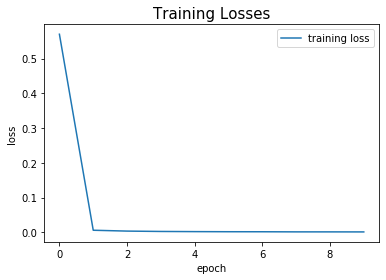

In [12]:
plt.plot(history.history['loss'])
plt.title('Training Losses',size = 15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss'], loc='upper right')
plt.show()

In [13]:
x_train_embedding = branch_model.predict(x_train)
x_test_embedding = branch_model.predict(x_test)

tsne = TSNE(n_components=2, random_state= 4)
train_tsne_embeds = tsne.fit_transform(x_train_embedding)
test_tsne_embeds = tsne.fit_transform(x_test_embedding)

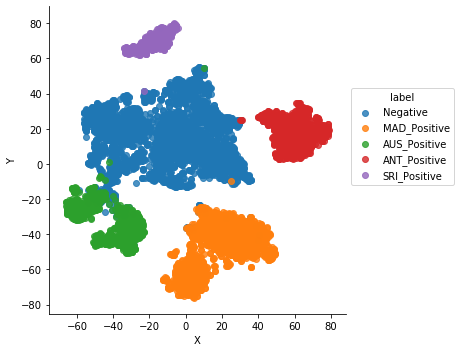

In [14]:
scatterDF =  pd.DataFrame(
    {'X': train_tsne_embeds[:,0],
     'Y': train_tsne_embeds[:,1],
     'Label': y_train
    })

scatter_plot = sns.lmplot(data=scatterDF, x='X', y='Y', hue='Label', fit_reg=False, legend=False)

legend = scatter_plot.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

for i, text in enumerate(legend.get_texts()):
    plt.setp(text,color = 'black')

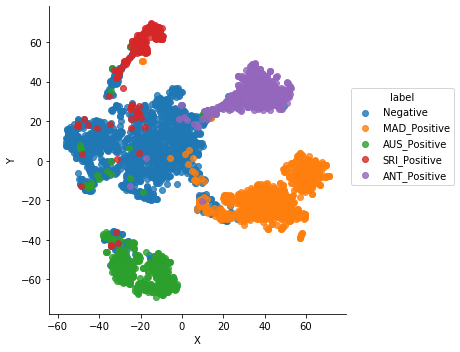

In [15]:
scatterDF =  pd.DataFrame(
    {'X': test_tsne_embeds[:,0],
     'Y': test_tsne_embeds[:,1],
     'Label': y_test
    })

scatter_plot = sns.lmplot(data=scatterDF, x='X', y='Y', hue='Label', fit_reg=False, legend=False)
legend = scatter_plot.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

for i, text in enumerate(legend.get_texts()):
    plt.setp(text,color = 'black')

In [21]:
model_dir = os.getcwd() + '/Model/'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

branch_model.save_weights(model_dir + 'weights_4species_classification_siamese_network.h5')

Build Multi-classification model

In [16]:
def dist_diff_square(a,b):
    return np.sum(np.square(a-b))

def pred(k_nearest_neighbors):
    pred_test = pd.DataFrame()
    pred_test['spectrogram_filename'] = [spectrogram_filename.split('Extracted_Spectrogram/')[-1] for spectrogram_filename in spectrogram_filenames_test]
    pred_test['true_species_id'] = y_test
    pred_test['pred_species_id'] = None
    pred_test['pred_correct'] = 0
    for i in range(len(pred_test)):
        distance_with_each_species = []
        for species_id in species_id_list:
            species_id_train_index = [index for index, x in enumerate(y_train) if x == species_id]
            x_train_embedding_species_id = x_train_embedding[species_id_train_index]
            embedding_distance_species_id = [dist_diff_square(x_test_embedding[i], embedding) for embedding in x_train_embedding_species_id] 
            k_nearest_neighbors_species_id = sort(embedding_distance_species_id)[:k_nearest_neighbors]
            distance_with_each_species.append(mean(k_nearest_neighbors_species_id))
        most_similar_species_sorted = [species_id_list[i] for i in np.argsort(distance_with_each_species)]
        pred_test.at[i,'pred_species_id'] = most_similar_species_sorted[0]
        pred_test.at[i, 'pred_correct'] = int(y_test[i] in most_similar_species_sorted[0])
    return pred_test

In [14]:
pred_test_1_neighbor = pred(k_nearest_neighbors = 1)
pred_test_3_neighbor = pred(k_nearest_neighbors = 3)
pred_test_5_neighbor = pred(k_nearest_neighbors = 5)
pred_test_10_neighbor = pred(k_nearest_neighbors = 10)

print('accuracy for test set with closest 1 neighbor: ', "{0:.2%}".format(sum(pred_test_1_neighbor.pred_correct) / len(pred_test_1_neighbor)))
print('accuracy for test set with closest 1 neighbors: ', "{0:.2%}".format(sum(pred_test_3_neighbor.pred_correct) / len(pred_test_3_neighbor)))
print('accuracy for test set with closest 5 neighbors: ', "{0:.2%}".format(sum(pred_test_5_neighbor.pred_correct) / len(pred_test_5_neighbor)))
print('accuracy for test set with closest 10 neighbors: ', "{0:.2%}".format(sum(pred_test_10_neighbor.pred_correct) / len(pred_test_10_neighbor)))

accuracy for test set with closest 1 neighbor:  91.72%
accuracy for test set with closest 1 neighbors:  91.97%
accuracy for test set with closest 5 neighbors:  92.19%
accuracy for test set with closest 10 neighbors:  92.21%


In [15]:
confusion_matrix = pd.crosstab(pred_test_10_neighbor['true_species_id'], pred_test_10_neighbor['pred_species_id'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted     ANT_Positive  AUS_Positive  MAD_Positive  Negative  SRI_Positive
Actual                                                                        
ANT_Positive           425             0             0        23             0
AUS_Positive             0           392             0        42             4
MAD_Positive             0             0           749        33             1
Negative                21            58            48      1631             9
SRI_Positive             0             0             0        45           166
